<center><h1 style="font-size:2.5vw"> AML Project 2 </h1></center>

---
<div style="display:flex; flex-direction:row; width:35%; justify-content : space-between">
    <div style = "display : flex, flex-direction : column">
        <div><b><font color = "#3285d3">Authors</font></b></div>
        <div><b><font color = "#3285d3">Date</font></b></div>
    </div>
    <div style = "display : flex, flex-direction : column">
        <div><b>&nbsp;&nbsp;:&nbsp;&nbsp;</b></div>
        <div><b>&nbsp;&nbsp;:&nbsp;&nbsp;</b></div>
    </div>
    <div style = "display : flex, flex-direction : column">
        <div>Albert Roathel, Marcel Affi</div>
        <div>April 2021</div>
    </div>
</div>

Feature selection is the process of selecting a subset of relevant features used to train a machine learning model, in this project we have been challenged to use these feature selection methods on two datasets :

<table style="width:100%">
  <tr>
    <th style="text-align:left">Dataset</th>
    <th style="text-align:left">Features</th>
    <th style="text-align:left">Train observations</th>
    <th style="text-align:left">Val observations</th>
  </tr>
  <tr>
    <td style="text-align:left">Artificial</td>
    <td style="text-align:left">500</td>
    <td style="text-align:left">2000</td>
    <td style="text-align:left">600</td>
  </tr>
  <tr>
    <td style="text-align:left">Digits</td>
    <td style="text-align:left">5000</td>
    <td style="text-align:left">6000</td>
    <td style="text-align:left">1000</td>
  </tr>
</table>

# Project outline

1. [Loading Data](#Loading_data)
2. [ElasticNet](#ElasticNet)
3. [Trees](#Trees)
4. [Recursive feature elimination](#RFE)
5. [Boruta](#Boruta)
5. [XGBoost](#XGBoost)

In [138]:
%config Completer.use_jedi = False

import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import ElasticNetCV, Lasso
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (10,5)
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['grid.color'] = 'w'
plt.style.use(['ggplot'])

import plotly.express as px
import plotly.graph_objects as go

<a id='Loading_data'></a>
# Load and transform the data

In [49]:
def read_from_url(dataset : str) -> (pd.DataFrame):
    train_data   = pd.read_csv(f'https://pages.mini.pw.edu.pl/~teisseyrep/TEACHING/AML/Project2/{dataset}_train.data', sep = ' ', header=None).iloc[:,:-1].values
    valid_data   = pd.read_csv(f'https://pages.mini.pw.edu.pl/~teisseyrep/TEACHING/AML/Project2/{dataset}_valid.data', sep = ' ', header=None).iloc[:,:-1].values
    train_labels = pd.read_csv(f'https://pages.mini.pw.edu.pl/~teisseyrep/TEACHING/AML/Project2/{dataset}_train.labels', header=None).values.ravel()

    return train_data, train_labels, valid_data

In [50]:
X_art, y_art, val_art = read_from_url('artificial')
X_dig, y_dig, val_dig = read_from_url('digits')

In [89]:
# Utility function to save the results
def save_to_file(dataset : str, predictions : np.array, feature_indices : list()):
    with open (f'ALBROA_{dataset}_features.txt', 'w+') as buffer:
        buffer.write("\"ALBROA\"\n")
        for feature_index in feature_indices:
            buffer.write(str(feature_index) + '\n')
    
    with open (f'ALBROA_{dataset}_predictions.txt', 'w+') as buffer:
        buffer.write("\"ALBROA\"\n")
        for prediction in predictions:
            buffer.write(str(prediction) + '\n')

In [51]:
print(f'Artifitial dataset: {X_art.shape[0]} observations, {X_art.shape[1]} features')
print(f'Digits dataset: {X_dig.shape[0]} observations, {X_dig.shape[1]} features')

Artifitial dataset: 2000 observations, 500 features
Digits dataset: 6000 observations, 5000 features


In [98]:
X_art = (X_art - X_art.mean(0)) / X_art.std()
val_art = (val_art - val_art.mean(0)) / val_art.std()

In [53]:
std = X_dig.std(0)
X_dig = X_dig[:, std != 0]
X_dig = (X_dig - X_dig.mean(0)) / std[std != 0]


In [54]:
X_art_train, X_art_test, y_art_train, y_art_test = sklearn.model_selection.train_test_split(
    X_art, y_art, test_size=0.33, random_state=42)

X_dig_train, X_dig_test, y_dig_train, y_dig_test = sklearn.model_selection.train_test_split(
    X_dig, y_dig, test_size=0.33, random_state=42)

<a id='ElasticNet'></a>
# ElasticNet

In [55]:
elasticnet = ElasticNetCV(
    l1_ratio=[0.05, 0.1, 0.2, 0.3, 0.5, 0.6, 0.9, 0.95, 0.99, 1],
    verbose=1
)

In [56]:
elasticnet.fit(X_art_train, y_art_train.flatten())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ElasticNetCV(l1_ratio=[0.05, 0.1, 0.2, 0.3, 0.5, 0.6, 0.9, 0.95, 0.99, 1],
             verbose=1)

In [57]:
elasticnet.l1_ratio_, elasticnet.alpha_

(1.0, 0.06543605558779328)

In [58]:
lasso = Lasso(alpha=0.06)
lasso.fit(X_art_train, y_art_train)

Lasso(alpha=0.06)

In [59]:
pred = np.ones(X_art_test.shape[0])
pred[lasso.predict(X_art_test) < 0] = -1

In [60]:
(pred == y_art_test).mean()

0.5848484848484848

In [61]:
art_lasso_selection = lasso.coef_ != 0

<a id='Trees'></a>
# Trees

In [67]:
X_dig_train.shape

(4020, 4955)

In [68]:
trees = ExtraTreesClassifier(n_estimators=500, criterion='gini', min_samples_split=10,
                    max_features=300)

In [69]:
trees.fit(X_art_train, y_art_train)

ExtraTreesClassifier(max_features=300, min_samples_split=10, n_estimators=500)

In [70]:
pred = np.ones(X_art_test.shape[0])
pred[trees.predict(X_art_test) < 0] = -1

In [18]:
(pred == y_art_test).mean()

0.8318181818181818

In [71]:
px.histogram(trees.feature_importances_)

In [72]:
mask = trees.feature_importances_ > 0.005
mask.sum()

20

In [73]:
trees_better = ExtraTreesClassifier(n_estimators=100, criterion='gini', max_depth=3,
                    max_features=5)

trees_better.fit(X_art_train[:,mask], y_art_train)
pred = np.ones(X_art_test.shape[0])
pred[trees.predict(X_art_test) < 0] = -1
(pred == y_art_test).mean()


0.843939393939394

## SVM

In [107]:
svm = SVC(C=1, kernel='rbf', gamma=0.1)
svm.fit(X_art_train[:, mask], y_art_train)

pred = np.ones(X_art_test.shape[0])
pred[svm.predict(X_art_test[:, mask]) < 0] = -1
(pred == y_art_test).mean()


0.906060606060606

In [103]:
indices, = np.where(mask == True)
val_pred = svm.predict(val_art[:, mask])
save_to_file(dataset='artificial',predictions=val_pred, feature_indices=indices.tolist())

In [23]:
svm = SVC(C=100, kernel='rbf', gamma=0.01)
svm.fit(X=X_art_train, y=y_art_train)

pred = np.ones(X_art_test.shape[0])
pred[svm.predict(X_art_test) < 0] = -1
(pred == y_art_test).mean()

0.6272727272727273

In [ ]:
importance = permutation_importance(svm, X=X_art_test[:, mask], y=y_art_test, n_repeats=2)

In [ ]:
px.histogram(importance['importances_mean'])

In [ ]:
mask = importance['importances_mean'] > 0.005
sum(mask)

In [24]:
svm = SVC(C=100, kernel='rbf', gamma=0.01)
svm.fit(X_art_train[:, mask], y_art_train)
pred = np.ones(X_art_test.shape[0])
pred[svm.predict(X_art_test[:, mask]) < 0] = -1
(pred == y_art_test).mean()

0.8727272727272727

<a id='RFE'></a>

# Recursive feature elimination

In [25]:
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE

In [26]:
gradboost = GradientBoostingClassifier(n_estimators=500, max_depth=10, max_features='auto')
gradboost.fit(X_art_train, y_art_train)
pred = np.ones(X_art_test.shape[0])
pred[gradboost.predict(X_art_test) < 0] = -1
(pred == y_art_test).mean()

0.7681818181818182

In [27]:
gradboost = GradientBoostingClassifier(n_estimators=500, max_depth=10, max_features='auto')
rfe = RFE(gradboost, n_features_to_select=20, step=50, verbose=1)
rfe.fit(X_art_train, y_art_train)

Fitting estimator with 500 features.
Fitting estimator with 450 features.
Fitting estimator with 400 features.
Fitting estimator with 350 features.
Fitting estimator with 300 features.
Fitting estimator with 250 features.
Fitting estimator with 200 features.
Fitting estimator with 150 features.
Fitting estimator with 100 features.
Fitting estimator with 50 features.


RFE(estimator=GradientBoostingClassifier(max_depth=10, max_features='auto',
                                         n_estimators=500),
    n_features_to_select=20, step=50, verbose=1)

In [28]:
art_rfe_selection = rfe.ranking_ == 1

In [29]:
pred = np.ones(X_art_test.shape[0])
pred[rfe.estimator_.predict(X_art_test[:, art_rfe_selection]) < 0] = -1
(pred == y_art_test).mean()

0.7803030303030303

<a id='Boruta'></a>
# Boruta

In [30]:
from boruta import BorutaPy

In [31]:
trees = ExtraTreesClassifier(n_estimators=100, criterion='gini', min_samples_split=10,
                    max_features='auto')
feat_selector = BorutaPy(trees, n_estimators='auto', verbose=2, random_state=1)
feat_selector.fit(X_art_train, y_art_train)
feat_selector.support_
feat_selector.ranking_
# X_filtered = feat_selector.transform(X)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	500
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	21
Rejected: 	479
Iteration: 	9 / 100
Confirmed: 	13
Tentative: 	8
Rejected: 	479
Iteration: 	10 / 100
Confirmed: 	13
Tentative: 	8
Rejected: 	479
Iteration: 	11 / 100
Confirmed: 	13
Tentative: 	8
Rejected: 	479
Iteration: 	12 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	479
Iteration: 	13 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	479
Iteration: 	14 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	479
Iteration: 	15 / 100
Confirmed: 	15
Tentative: 	6
Rejected: 	479
Iteration: 	16 / 100
Confirmed: 	16
Tenta

array([105, 316, 453, 435,  62,  53, 210, 341, 196,  87,  57,  72,  41,
       299, 165, 180,  24, 348,  19, 107, 348, 267, 432, 306, 177, 361,
        97, 385,   1, 280, 351, 468,  78, 220, 429,  75, 180, 440,  83,
       299, 416, 411, 336,  59, 228, 394,   1, 312,   1, 247, 169, 185,
       354,  14, 263, 110,  29, 387, 481, 293,  61, 476, 445, 268,   1,
       297, 343, 175, 220, 146, 400, 428, 397, 309,  65, 237, 225,  98,
        55, 116, 259, 118, 238, 241, 126, 201, 173, 327, 252, 452, 383,
       227, 365, 365, 245, 317, 426,  74, 388, 275, 210, 353,  60, 400,
       306,   1, 234, 467, 304, 148, 159, 173, 286, 402, 178, 236,  91,
        84, 460, 245, 165, 190, 337, 260,  76,  27, 201, 216,   1, 477,
        35, 163, 403, 301, 216, 310,   9,  99, 161, 208, 111, 308, 285,
       327, 248, 206, 112,  45,  68,  58, 266, 360, 231,   1, 233, 171,
        24, 220, 424, 379, 179,  30, 439, 161, 155,  53, 102,  93, 272,
       480, 385, 331, 127,  31, 183,  86, 151,   5, 408, 379,  6

In [32]:
trees = ExtraTreesClassifier(n_estimators=1000, criterion='gini', min_samples_split=10,
                    max_features='auto')
trees.fit(X_art_train[:, feat_selector.support_], y_art_train)
pred = np.ones(X_art_test.shape[0])
pred[trees.predict(X_art_test[:, feat_selector.support_]) < 0] = -1
(pred == y_art_test).mean()

0.8924242424242425

In [33]:
svm = SVC(C=1, kernel='rbf', gamma=0.1)
svm.fit(X_art_train[:, feat_selector.support_], y_art_train)

pred = np.ones(X_art_test.shape[0])
pred[svm.predict(X_art_test[:, feat_selector.support_]) < 0] = -1
(pred == y_art_test).mean()


0.8878787878787879

<a id='XGBoost'></a>
# XGBoost

### Atrificial dataset

In [139]:
import xgboost as xgb
import shap
dtrain = xgb.DMatrix(X_art_train, label=y_art_train)
dtest = xgb.DMatrix(X_art_test, label=y_art_test)

In [140]:
num_round = 4
param = {'max_depth':2, 'eta': 0.1}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
param['nthread'] = 5
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	eval-rmse:1.08279	train-rmse:1.08491
[1]	eval-rmse:1.05646	train-rmse:1.05614
[2]	eval-rmse:1.03617	train-rmse:1.03160
[3]	eval-rmse:1.01955	train-rmse:1.01216


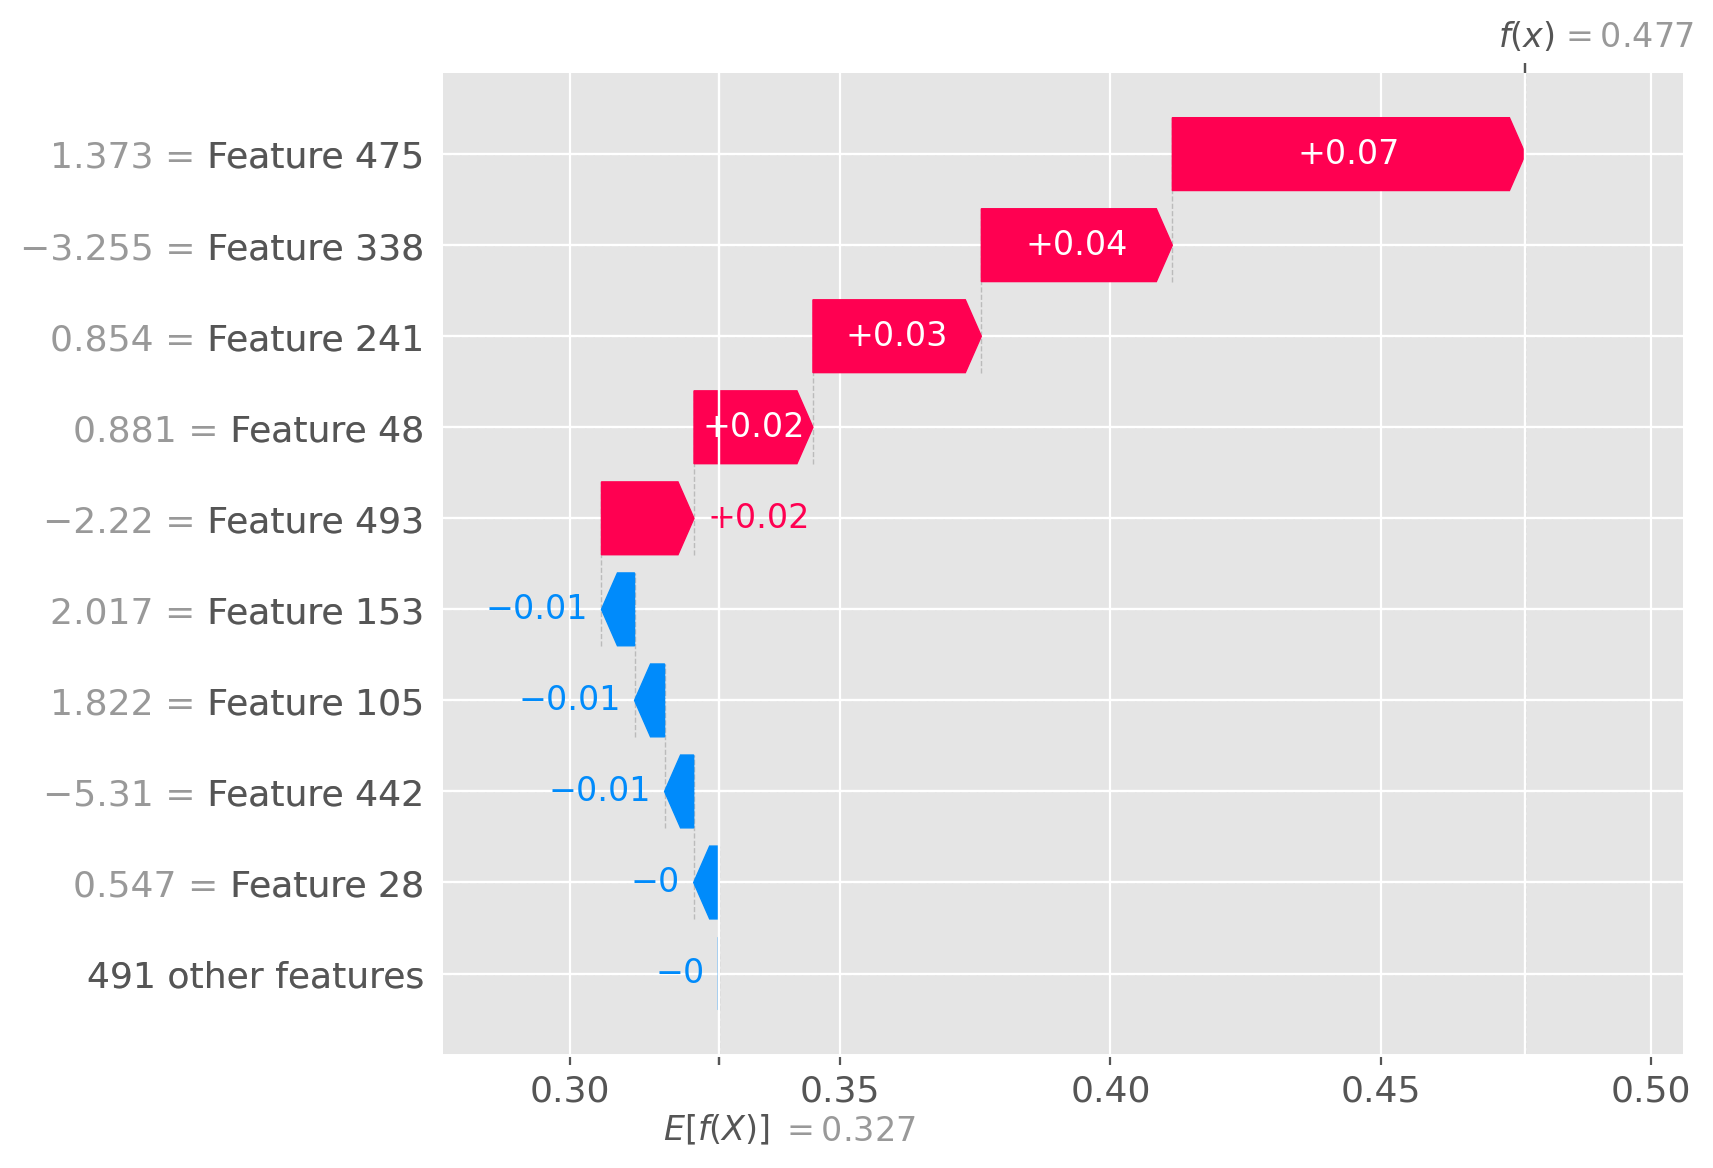

In [141]:
xgboost_explainer = shap.Explainer(bst)
xgboost_shap_values = xgboost_explainer(X_art_test)

# visualize the first prediction's explanation
shap.plots.waterfall(xgboost_shap_values[0])

### As you see in the graph, feature 475 has the most impact on the model 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

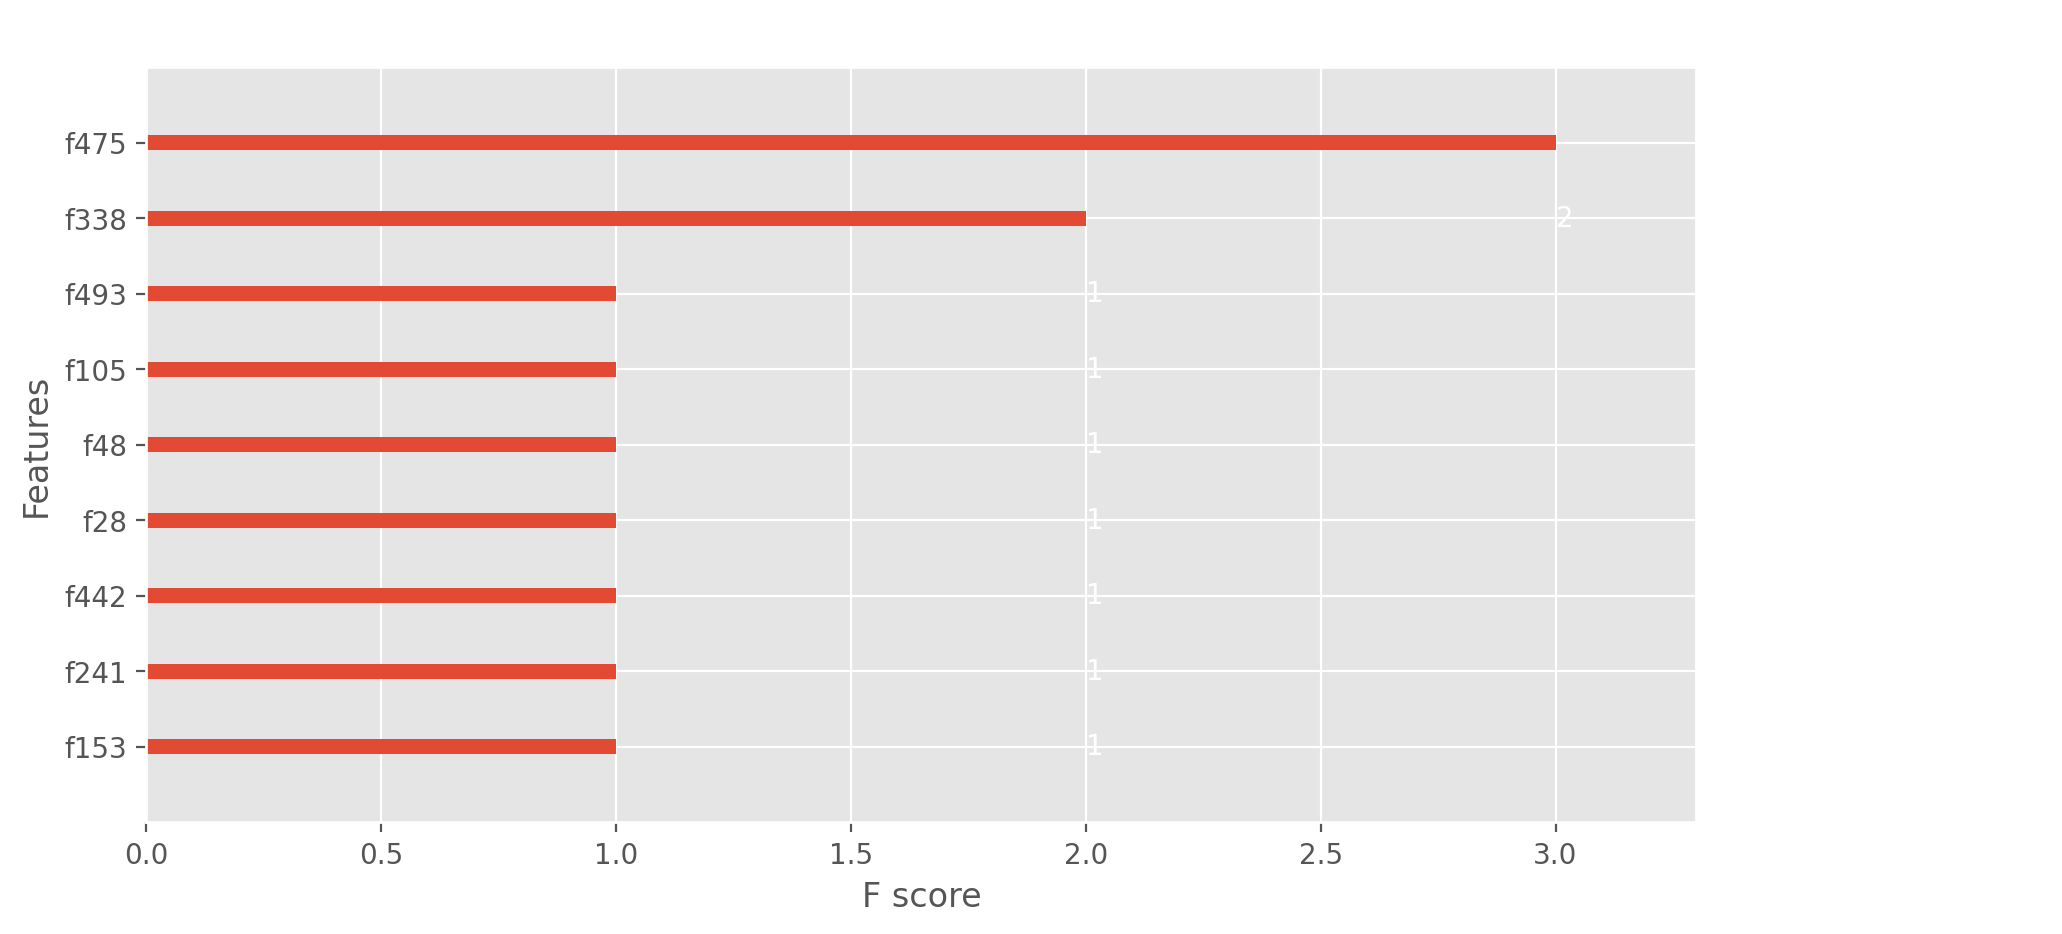

In [142]:
xgb.plot_importance(bst)

In [143]:
shap.initjs()
shap.plots.force(xgboost_shap_values[0])

### here you can compare the SHAP value for feature 475 as compared to other features, to do so just change the index from 475 to any other feature index

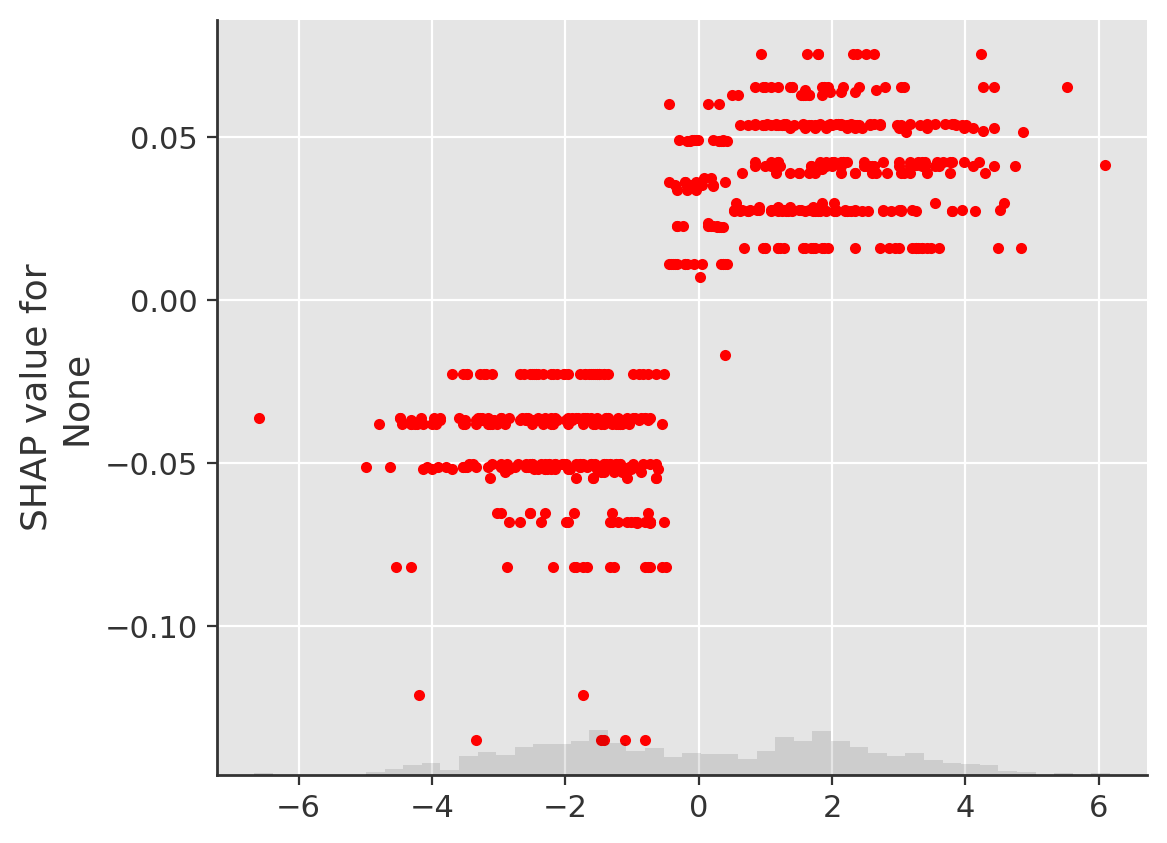

In [144]:
shap.initjs()
shap.plots.scatter(xgboost_shap_values[:,475], color='red')

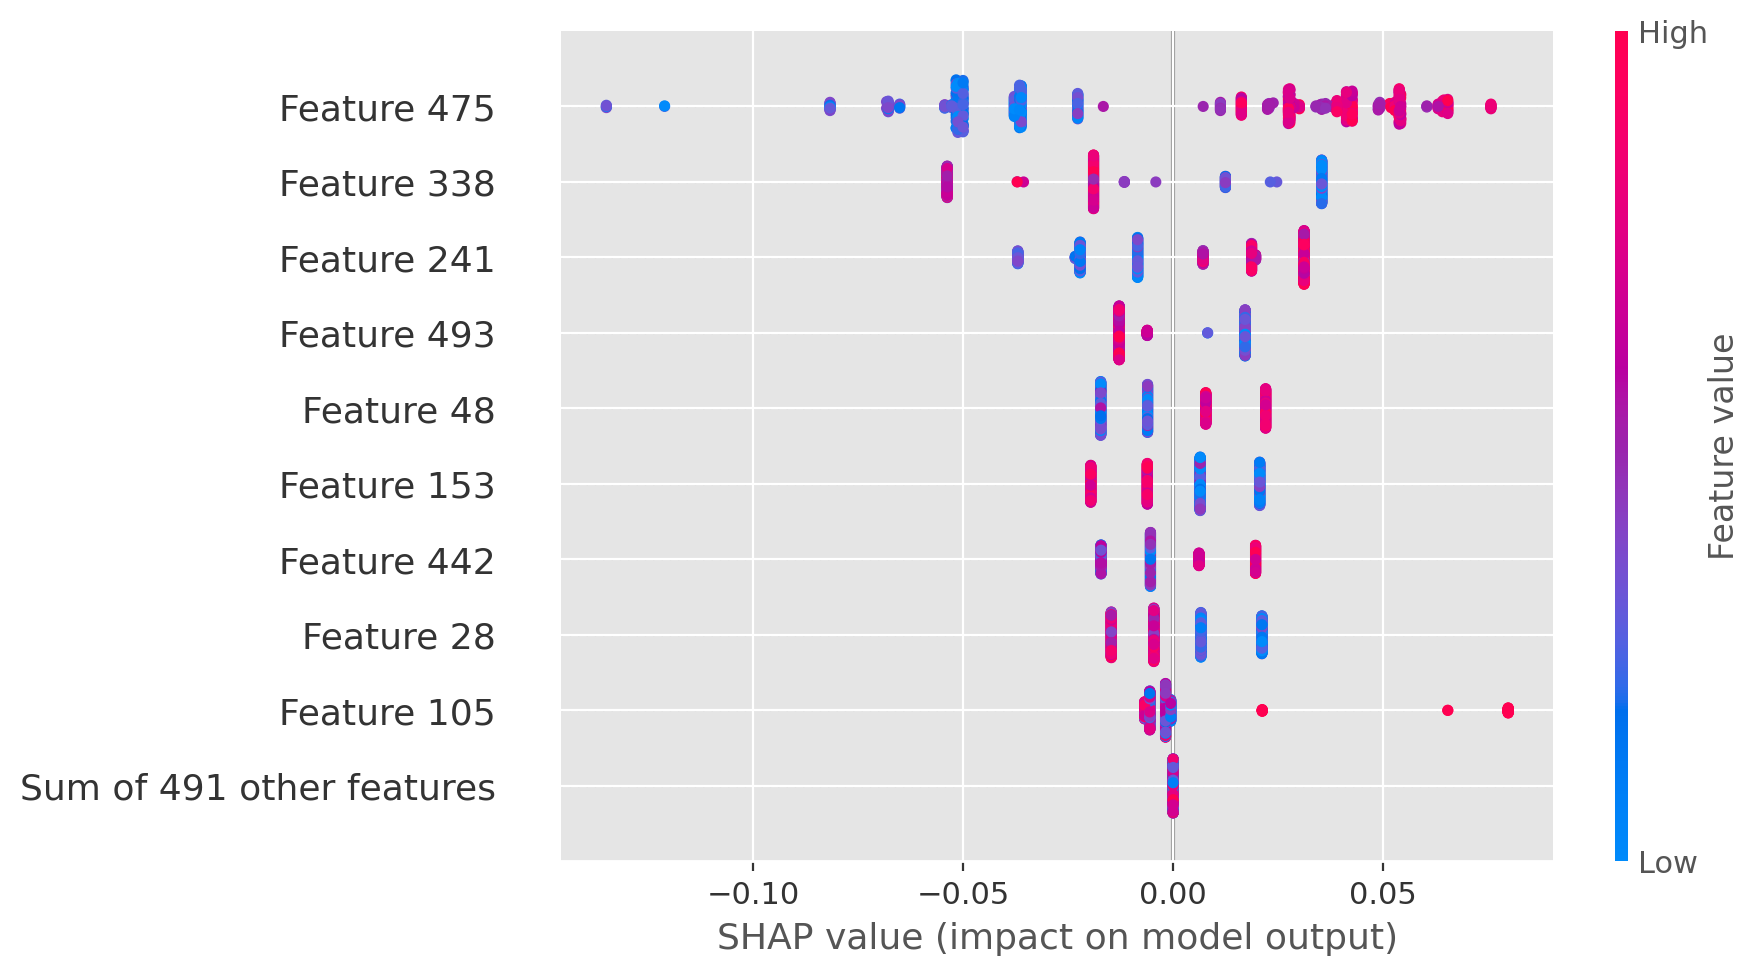

In [145]:
shap.plots.beeswarm(xgboost_shap_values)

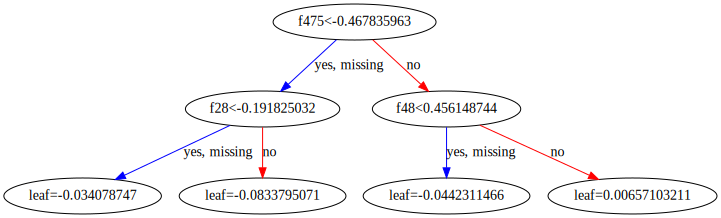

In [146]:
xgb.to_graphviz(bst, num_trees=2)

In [147]:
N = len(bst.get_fscore())
total = np.array(list(bst.get_fscore().values())).sum()
importances = bst.get_fscore()
importances.update((x, y/total) for x, y in importances.items())
importances_list = np.zeros(X_art.shape[1])
for feature, importance in importances.items():
    importances_list[int(feature.split('f')[1])] = importance

In [148]:
selected_importances = {feature:importance for feature, importance in importances.items() if importance > 0.05}
selected_importances

{'f475': 0.25,
 'f153': 0.08333333333333333,
 'f338': 0.16666666666666666,
 'f241': 0.08333333333333333,
 'f442': 0.08333333333333333,
 'f28': 0.08333333333333333,
 'f48': 0.08333333333333333,
 'f105': 0.08333333333333333,
 'f493': 0.08333333333333333}

In [149]:
important_features = importances_list > 0.05

In [150]:
svm = SVC(C=1, kernel='rbf', gamma=0.1)
svm.fit(X_art_train[:, important_features], y_art_train)

pred = np.ones(X_art_test.shape[0])
pred[svm.predict(X_art_test[:, important_features]) < 0] = -1
(pred == y_art_test).mean()

0.896969696969697

### Digits dataset

In [151]:
dtrain = xgb.DMatrix(X_dig_train, label=y_dig_train)
dtest = xgb.DMatrix(X_dig_test, label=y_dig_test)

In [152]:
num_round = 4
param = {'max_depth':2, 'eta': 0.1}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
param['nthread'] = 5
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	eval-rmse:1.04461	train-rmse:1.04003
[1]	eval-rmse:0.97866	train-rmse:0.97340
[2]	eval-rmse:0.92039	train-rmse:0.91545
[3]	eval-rmse:0.86566	train-rmse:0.86110


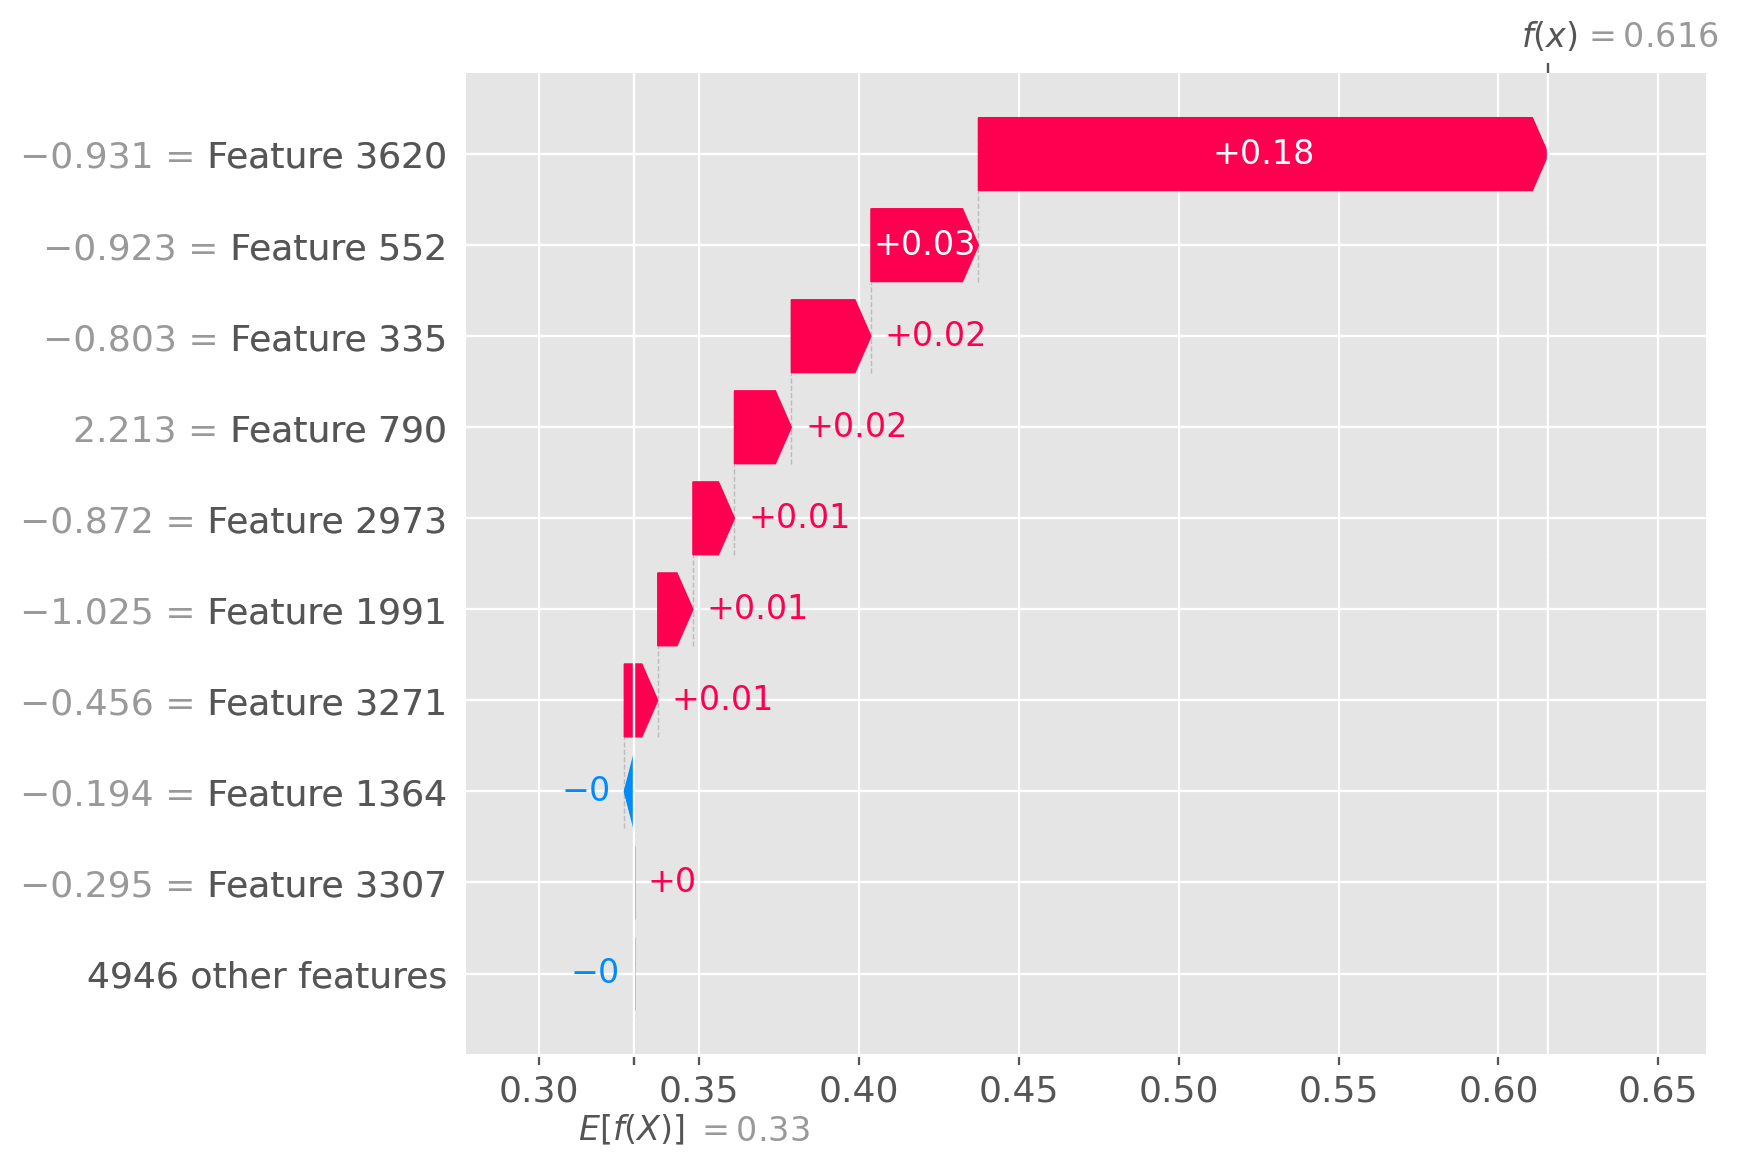

In [153]:
xgboost_explainer = shap.Explainer(bst)
xgboost_shap_values = xgboost_explainer(X_dig_test)

# visualize the first prediction's explanation
shap.plots.waterfall(xgboost_shap_values[0])

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

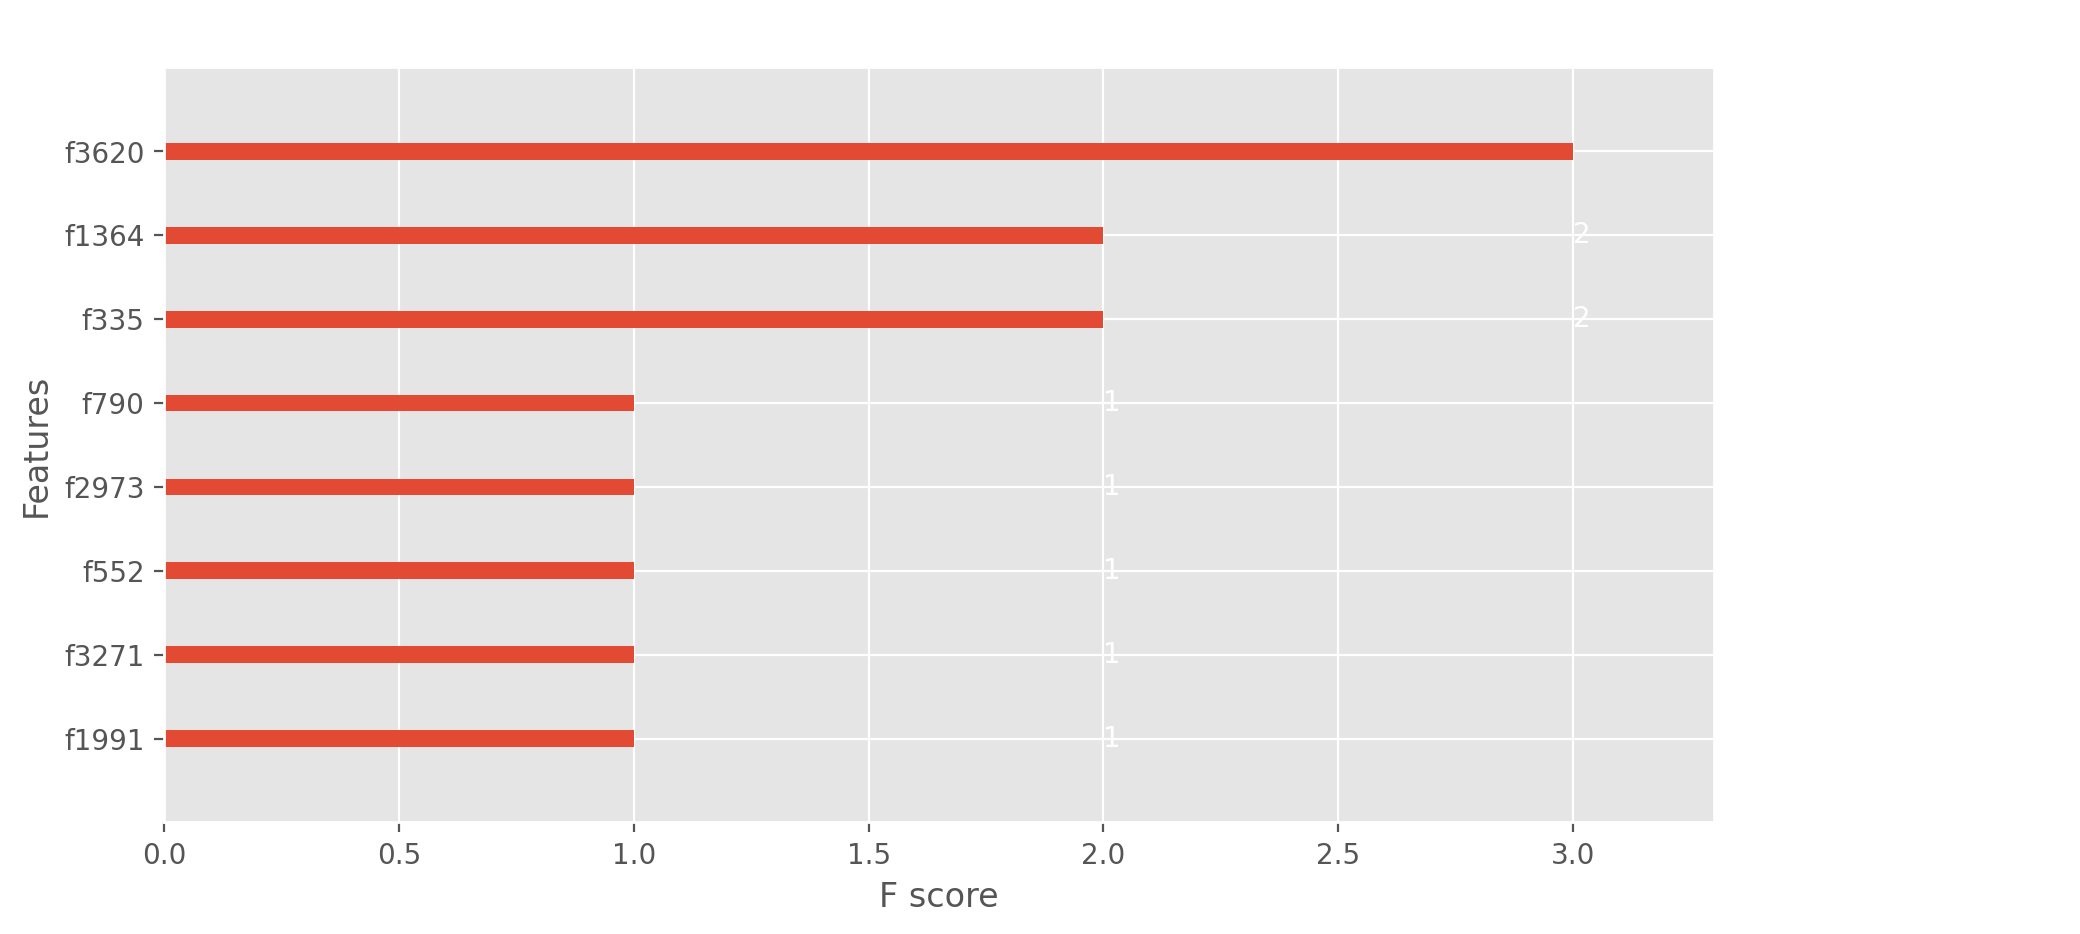

In [154]:
xgb.plot_importance(bst)

In [155]:
shap.initjs()
shap.plots.force(xgboost_shap_values[0])

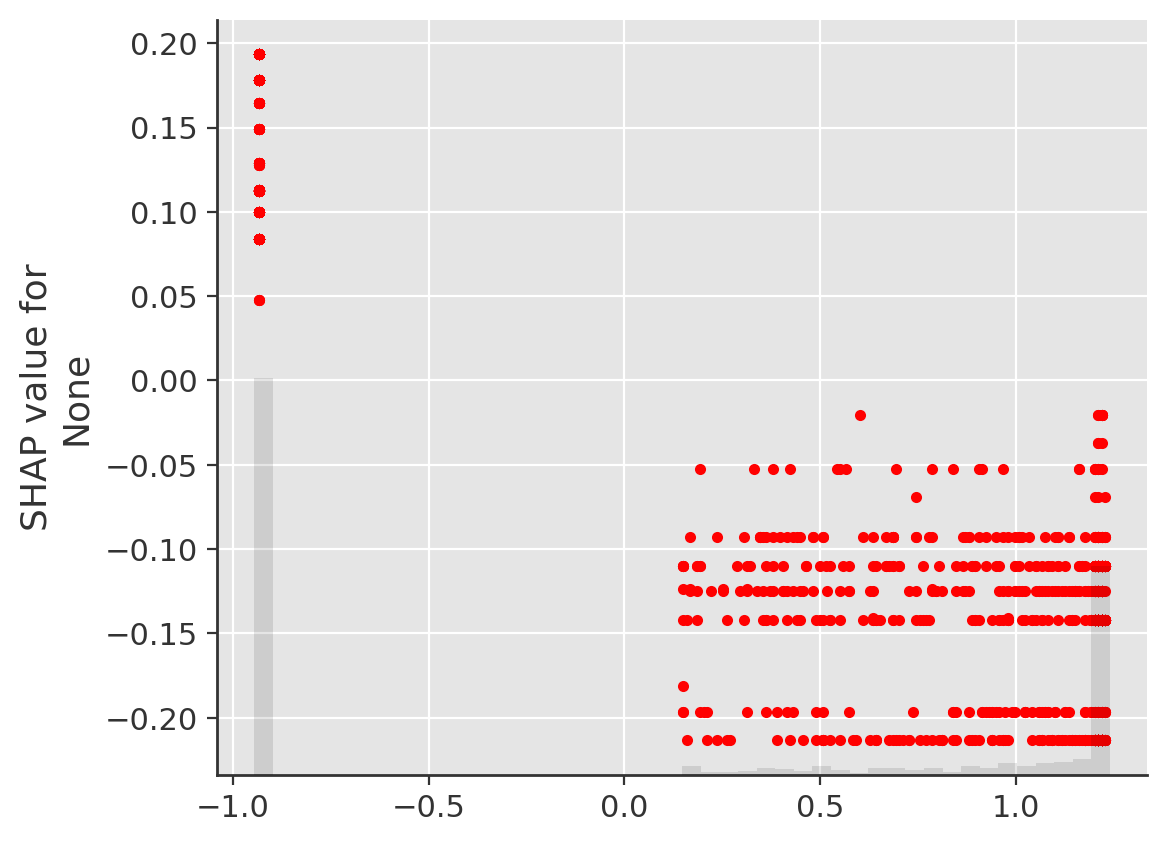

In [156]:
shap.initjs()
shap.plots.scatter(xgboost_shap_values[:,3620], color='red')

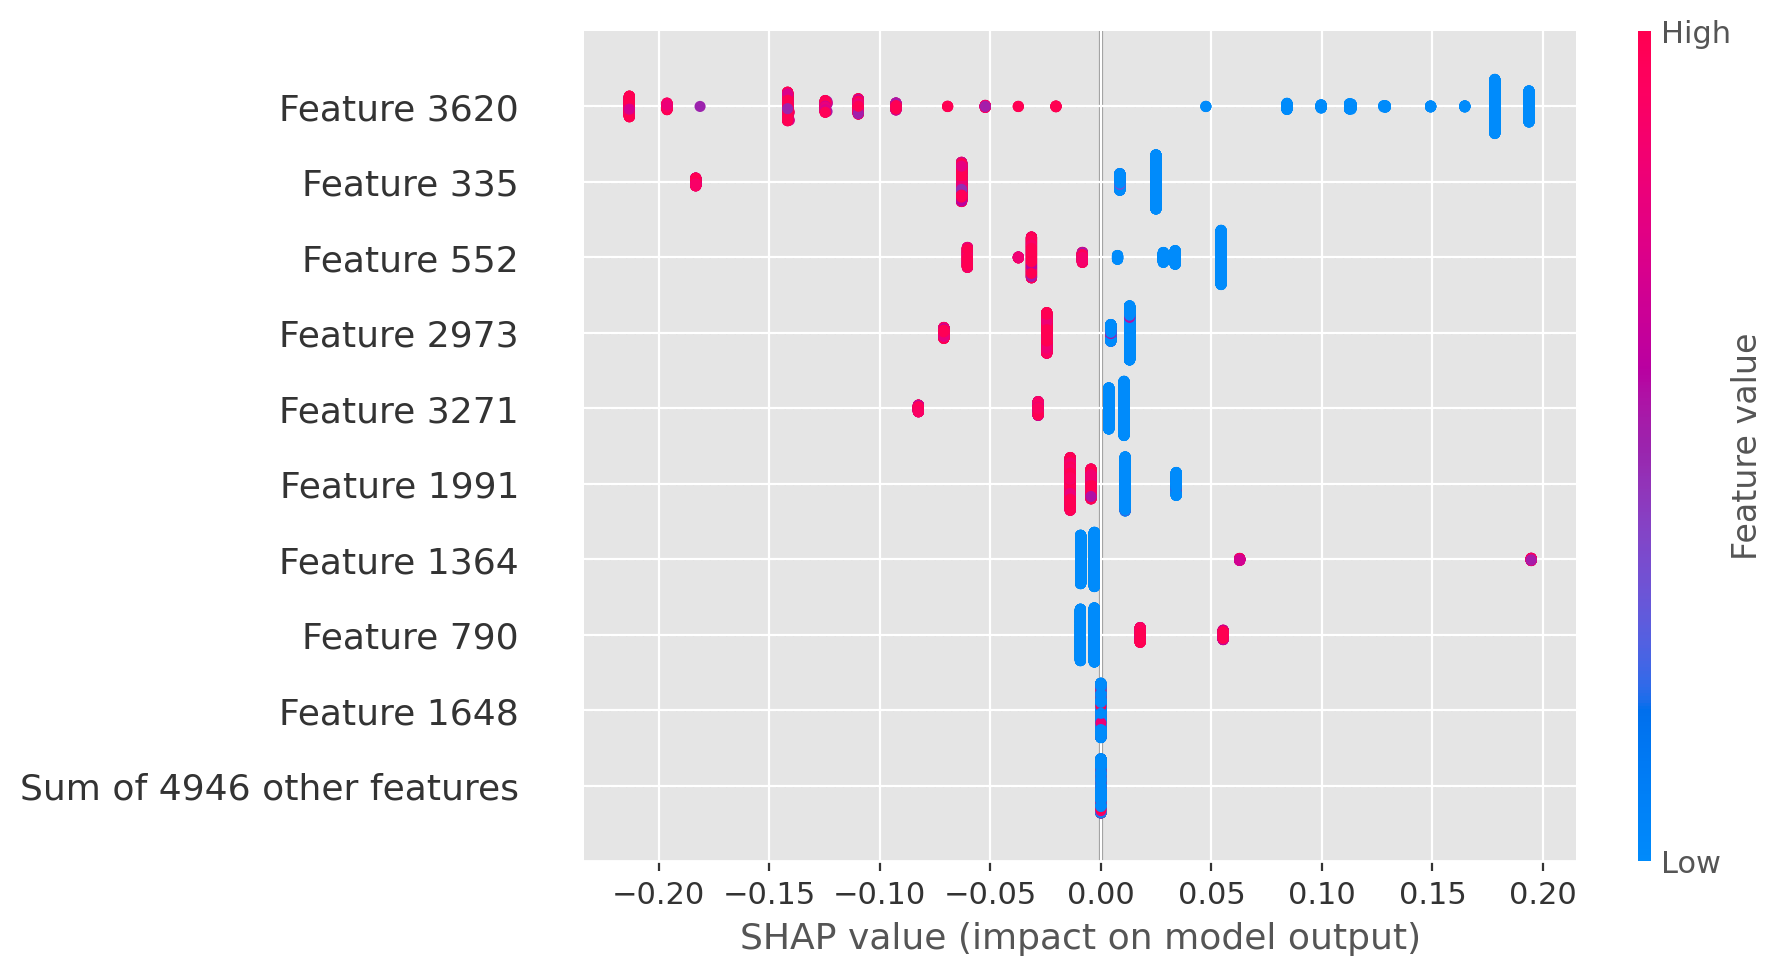

In [157]:
shap.plots.beeswarm(xgboost_shap_values)

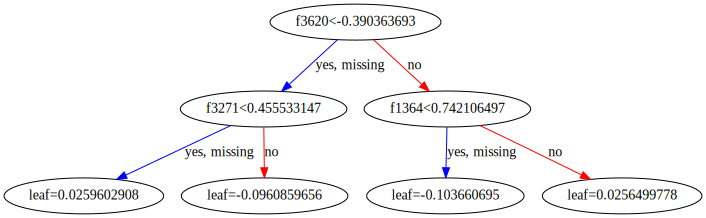

In [158]:
xgb.to_graphviz(bst, num_trees=2)

In [159]:
N = len(bst.get_fscore())
total = np.array(list(bst.get_fscore().values())).sum()
importances = bst.get_fscore()
importances.update((x, y/total) for x, y in importances.items())
importances_list = np.zeros(X_dig.shape[1])
for feature, importance in importances.items():
    importances_list[int(feature.split('f')[1])] = importance

In [160]:
selected_importances = {feature:importance for feature, importance in importances.items() if importance > 0.05}
selected_importances

{'f3620': 0.25,
 'f335': 0.16666666666666666,
 'f1364': 0.16666666666666666,
 'f1991': 0.08333333333333333,
 'f3271': 0.08333333333333333,
 'f552': 0.08333333333333333,
 'f2973': 0.08333333333333333,
 'f790': 0.08333333333333333}

In [161]:
important_features = importances_list > 0.05

In [162]:
svm = SVC(C=1, kernel='rbf', gamma=0.1)
svm.fit(X_dig_train[:, important_features], y_dig_train)

pred = np.ones(X_dig_test.shape[0])
pred[svm.predict(X_dig_test[:, important_features]) < 0] = -1
(pred == y_dig_test).mean()

0.9212121212121213